<a href="https://colab.research.google.com/github/desbaa32/Master2BD_tp_pro/blob/master/segmentation_images_ModuleIndexation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 33.8 MB/s eta 0:00:00


Saving 11xp-virus-streets-pix1-articleLarge.webp to 11xp-virus-streets-pix1-articleLarge.webp


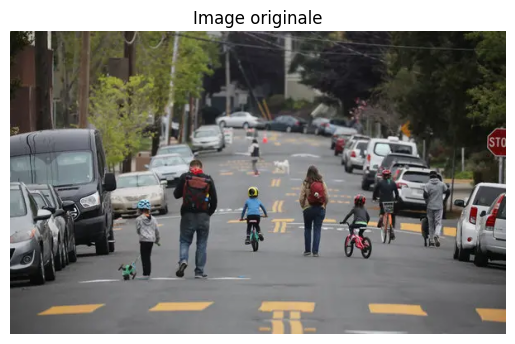

model_final_c10459.pkl: 184MB [00:03, 60.7MB/s]                           
/usr/local/lib/python3.12/dist-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


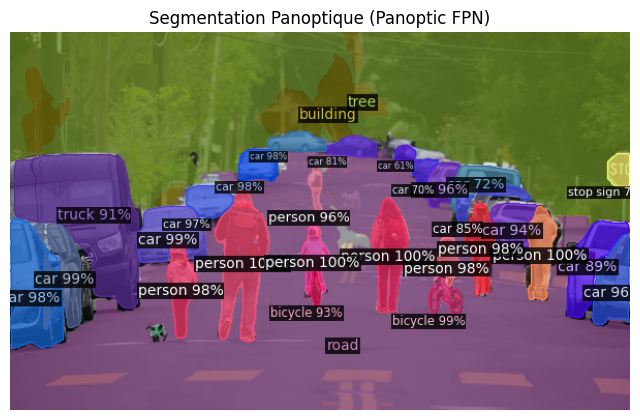

model_final_f10217.pkl: 178MB [00:00, 185MB/s]                           


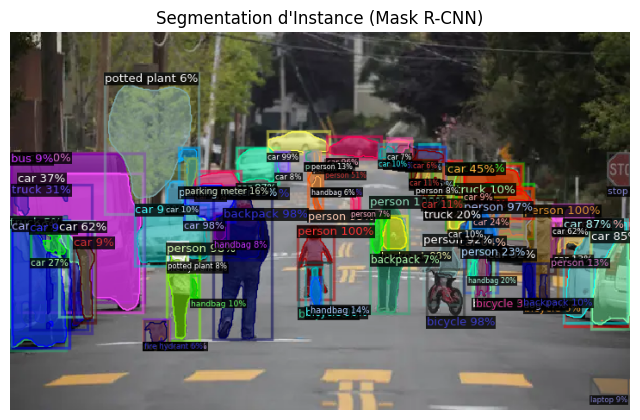

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


100%|██████████| 233M/233M [00:01<00:00, 131MB/s]


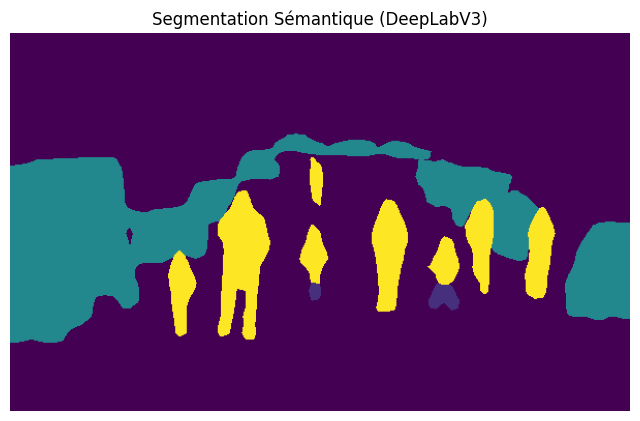

In [ ]:
# ============================================================
# Segmentation Sémantique, d'Instance et Panoptique
# ============================================================

# Installation de Detectron2 (sur Google Colab)
!pip install -q torch torchvision torchaudio
!pip install -q git+https://github.com/facebookresearch/detectron2.git

# Importations
import cv2
import numpy as np
import matplotlib.pyplot as plt
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import urllib.request

# ------------------------------------------------------------
# Charger une image d'exemple
# ------------------------------------------------------------
from google.colab import files
uploaded = files.upload()

image_path = list(uploaded.keys())[0]
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.axis("off")
plt.title("Image originale")
plt.show()

# ------------------------------------------------------------
# Segmentation PANOPTIQUE (FPN)
# ------------------------------------------------------------
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_50_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_50_3x.yaml")
cfg.MODEL.DEVICE = "cpu"

predictor = DefaultPredictor(cfg)
panoptic_seg, segments_info = predictor(image)["panoptic_seg"]

v = Visualizer(image, MetadataCatalog.get(cfg.DATASETS.TRAIN[0]))
out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
plt.figure(figsize=(8,6))
plt.imshow(out.get_image())
plt.title("Segmentation Panoptique (Panoptic FPN)")
plt.axis('off')
plt.show()

# ------------------------------------------------------------
# Segmentation D'INSTANCE (Mask R-CNN)
# ------------------------------------------------------------
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.DEVICE = "cpu"

predictor = DefaultPredictor(cfg)
outputs = predictor(image)

v = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize=(8,6))
plt.imshow(out.get_image()[:, :, ::-1])
plt.title("Segmentation d'Instance (Mask R-CNN)")
plt.axis('off')
plt.show()

# ------------------------------------------------------------
# Segmentation SÉMANTIQUE (DeepLabV3)
# ------------------------------------------------------------
import torch
from torchvision import models, transforms

deeplab = models.segmentation.deeplabv3_resnet101(pretrained=True).eval()
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(image).unsqueeze(0)
with torch.no_grad():
    output = deeplab(input_tensor)["out"][0]
segmentation = output.argmax(0).byte().cpu().numpy()

plt.figure(figsize=(8,6))
plt.imshow(segmentation)
plt.title("Segmentation Sémantique (DeepLabV3)")
plt.axis('off')
plt.show()